<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.5: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5).

Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb), [v1.5.2](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.2/AlphaFold2.ipynb), [v1.5.3-patch](https://colab.research.google.com/github/sokrypton/ColabFold/blob/56c72044c7d51a311ca99b953a71e552fdc042e1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

In [1]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MVIQRNSILLLIIIFASSISTCRSNVIDDNLFKQVYDNILEQEFAHDFQAYLSYLSKNIE SNNNIDKVDKNGIKVINVLSFGAKGDGKTYDNIAFEQAWNEACSSRTPVQFVVPKNKNYL LKQITFSGPCRSSISVKIFGSLEASSKISDYKDRRLWIAFDSVQNLVVGGGGTINGNGQV WWPSSCKINKSLPCRDAPTALTFWNCKNLKVNNLKSKNAQQIHIKFESCTNVVASNLMIN ASAKSPNTDGVHVSNTQYIQISDTIIGTGDDCISIVSGSQNVQATNITCGPGHGISIGSL GSGNSEAYVSNVTVNEAKIIGAENGVRIKTWQGGSGQASNIKFLNVEMQDVKYPIIIDQN YCDRVEPCIQQFSAVQVKNVVYENIKGTSATKVAIKFDCSTNFPCEGIIMENINLVGESG KPSEATCKNVHFNNAEHVTPHCTSLEISEDEALLYNY' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'mp4_tomato' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

jobname mp4_tomato_e68bf
sequence MVIQRNSILLLIIIFASSISTCRSNVIDDNLFKQVYDNILEQEFAHDFQAYLSYLSKNIESNNNIDKVDKNGIKVINVLSFGAKGDGKTYDNIAFEQAWNEACSSRTPVQFVVPKNKNYLLKQITFSGPCRSSISVKIFGSLEASSKISDYKDRRLWIAFDSVQNLVVGGGGTINGNGQVWWPSSCKINKSLPCRDAPTALTFWNCKNLKVNNLKSKNAQQIHIKFESCTNVVASNLMINASAKSPNTDGVHVSNTQYIQISDTIIGTGDDCISIVSGSQNVQATNITCGPGHGISIGSLGSGNSEAYVSNVTVNEAKIIGAENGVRIKTWQGGSGQASNIKFLNVEMQDVKYPIIIDQNYCDRVEPCIQQFSAVQVKNVVYENIKGTSATKVAIKFDCSTNFPCEGIIMENINLVGESGKPSEATCKNVHFNNAEHVTPHCTSLEISEDEALLYNY
length 457


In [2]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-Linux-x86_64.sh")
    os.system("bash Miniforge3-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=8.2.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

installing colabfold...
CPU times: user 112 ms, sys: 17.6 ms, total: 130 ms
Wall time: 35.4 s


In [3]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [4]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1", "alphafold2"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "3" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
#@markdown - if `auto` selected, will use `num_recycles=20` if `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use `tol=0.5` if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
relax_max_iterations = 200 #@param [0, 200, 2000] {type:"raw"}
#@markdown - max amber relax iterations, `0` = unlimited (AlphaFold2 default, can take very long)
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.
calc_extra_ptm = False #@param {type:"boolean"}
#@markdown - return pairwise chain iptm/actifptm

#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = True #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

You are logged into Google Drive and are good to go!


2025-06-07 14:17:03,669 Running on GPU
2025-06-07 14:17:03,986 Found 5 citations for tools or databases
2025-06-07 14:17:03,986 Query 1/1: mp4_tomato_e68bf (length 457)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


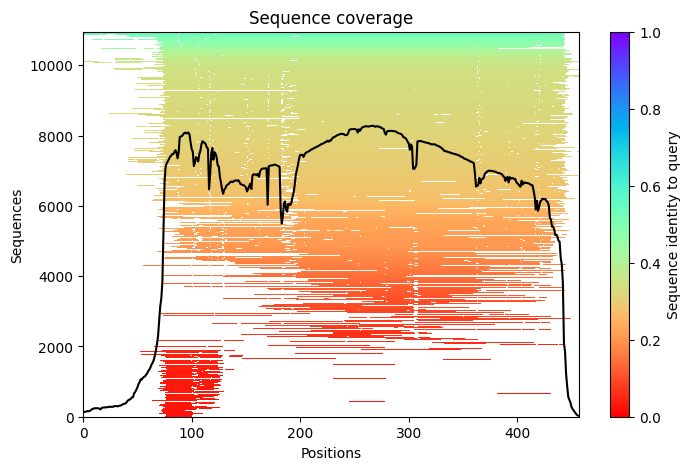

2025-06-07 14:17:09,967 Setting max_seq=512, max_extra_seq=5120
2025-06-07 14:19:02,091 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.1 pTM=0.808
2025-06-07 14:19:53,855 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.4 pTM=0.816 tol=7.73
2025-06-07 14:20:46,894 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.7 pTM=0.819 tol=6.05
2025-06-07 14:21:40,443 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=85.8 pTM=0.82 tol=2.17
2025-06-07 14:21:40,446 alphafold2_ptm_model_1_seed_000 took 248.5s (3 recycles)


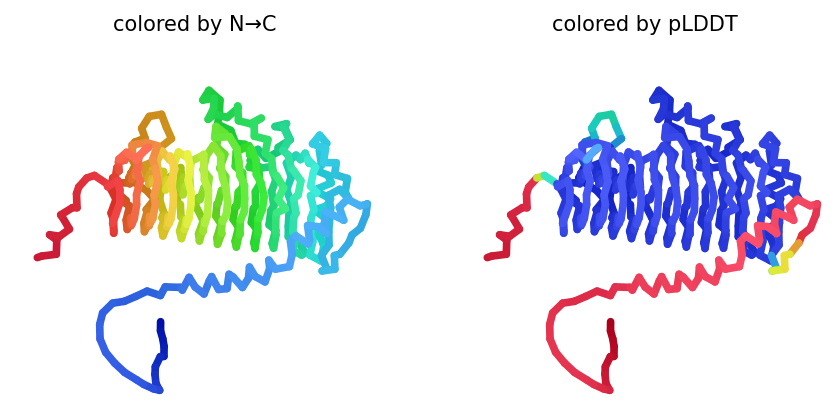

2025-06-07 14:22:34,572 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=85.8 pTM=0.816
2025-06-07 14:23:28,028 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=85.8 pTM=0.822 tol=5.53
2025-06-07 14:24:21,433 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=85.9 pTM=0.819 tol=2.03
2025-06-07 14:25:14,941 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=85.8 pTM=0.818 tol=0.985
2025-06-07 14:25:14,943 alphafold2_ptm_model_2_seed_000 took 213.8s (3 recycles)


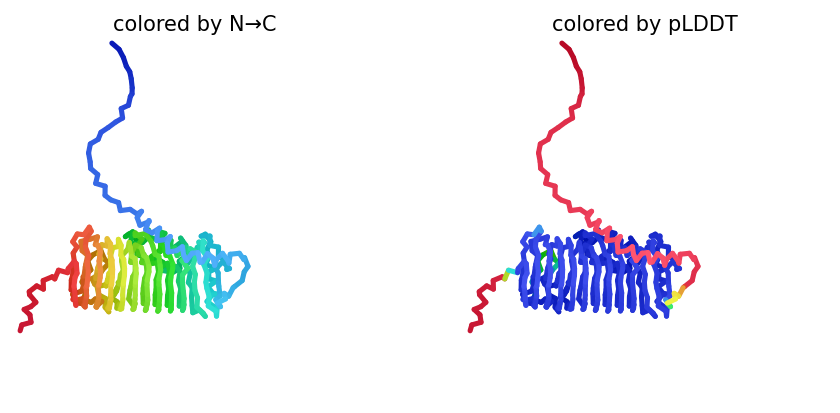

2025-06-07 14:26:09,018 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=85.9 pTM=0.81
2025-06-07 14:27:03,126 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=86.7 pTM=0.824 tol=7.58
2025-06-07 14:27:56,644 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=86.8 pTM=0.825 tol=0.981
2025-06-07 14:28:50,166 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=86.8 pTM=0.819 tol=1.6
2025-06-07 14:28:50,169 alphafold2_ptm_model_3_seed_000 took 214.8s (3 recycles)


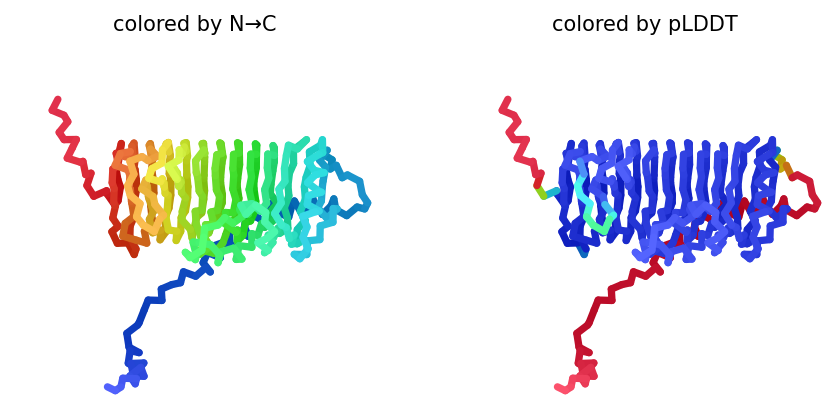

2025-06-07 14:29:43,995 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=86 pTM=0.815
2025-06-07 14:30:37,533 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=86.3 pTM=0.822 tol=12
2025-06-07 14:31:31,135 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=86.7 pTM=0.827 tol=3.58
2025-06-07 14:32:24,649 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=86.9 pTM=0.823 tol=0.643
2025-06-07 14:32:24,650 alphafold2_ptm_model_4_seed_000 took 214.1s (3 recycles)


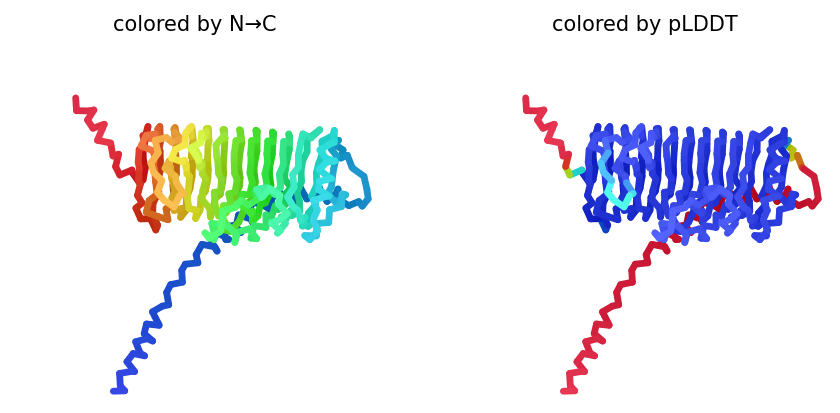

2025-06-07 14:33:18,813 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=85.6 pTM=0.815
2025-06-07 14:34:12,348 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=85.7 pTM=0.817 tol=2.71
2025-06-07 14:35:05,868 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=85.6 pTM=0.813 tol=3.69
2025-06-07 14:35:59,240 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=85.9 pTM=0.814 tol=3.57
2025-06-07 14:35:59,241 alphafold2_ptm_model_5_seed_000 took 214.1s (3 recycles)


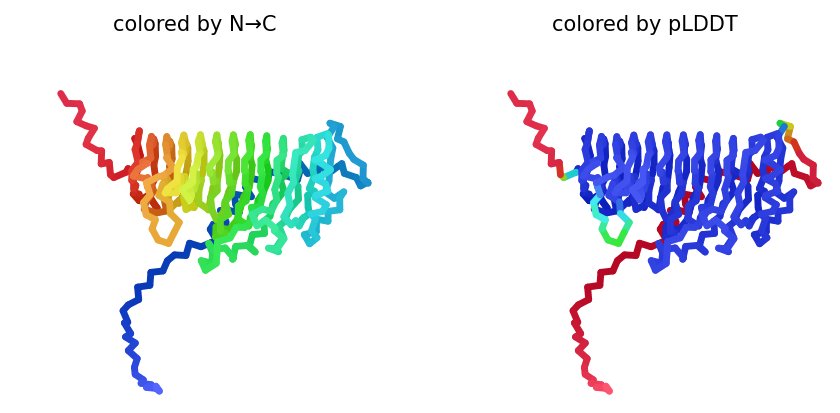

2025-06-07 14:35:59,754 reranking models by 'plddt' metric
2025-06-07 14:35:59,755 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=86.9 pTM=0.823
2025-06-07 14:35:59,755 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=86.8 pTM=0.819
2025-06-07 14:35:59,755 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=85.9 pTM=0.814
2025-06-07 14:35:59,755 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=85.8 pTM=0.818
2025-06-07 14:35:59,755 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=85.8 pTM=0.82
2025-06-07 14:36:01,499 Done


0

In [5]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

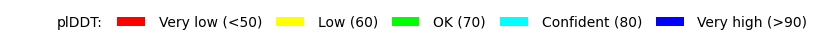

In [6]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()


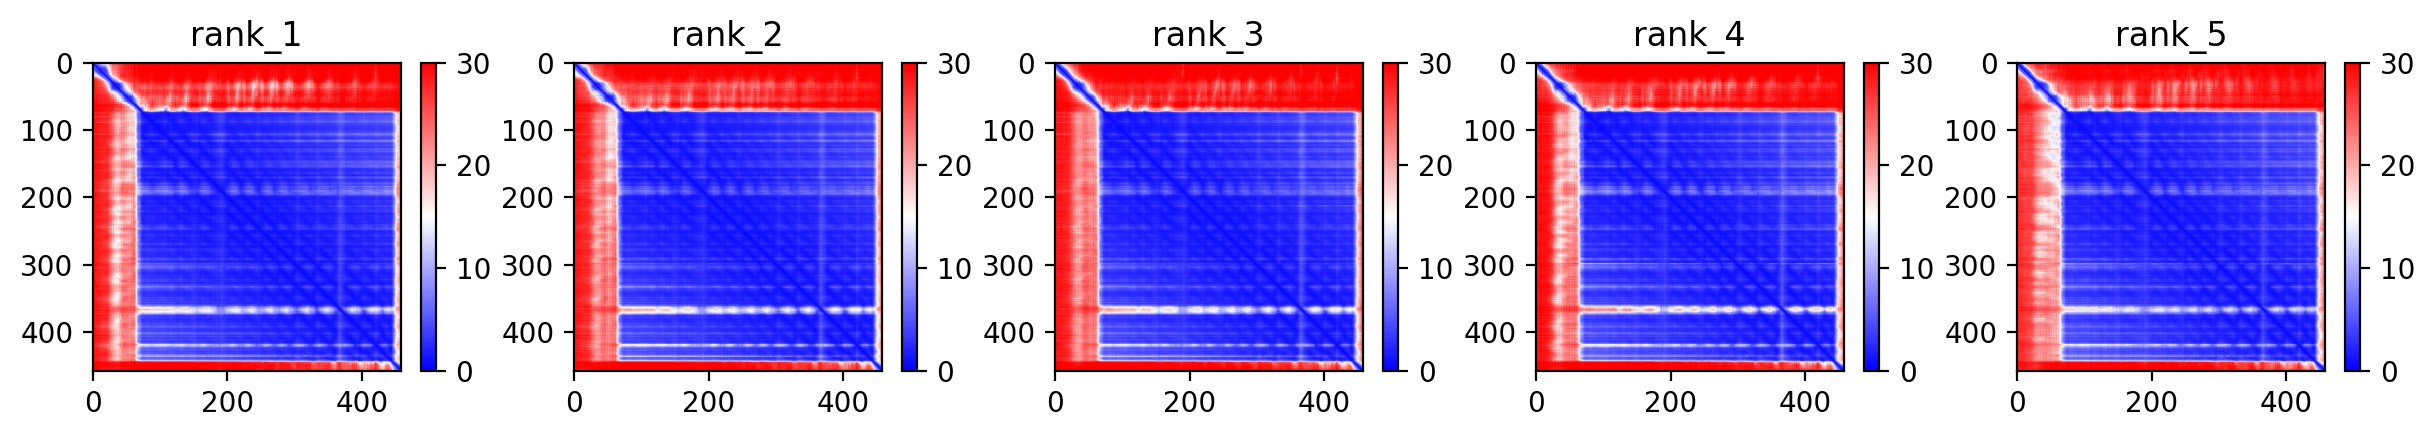
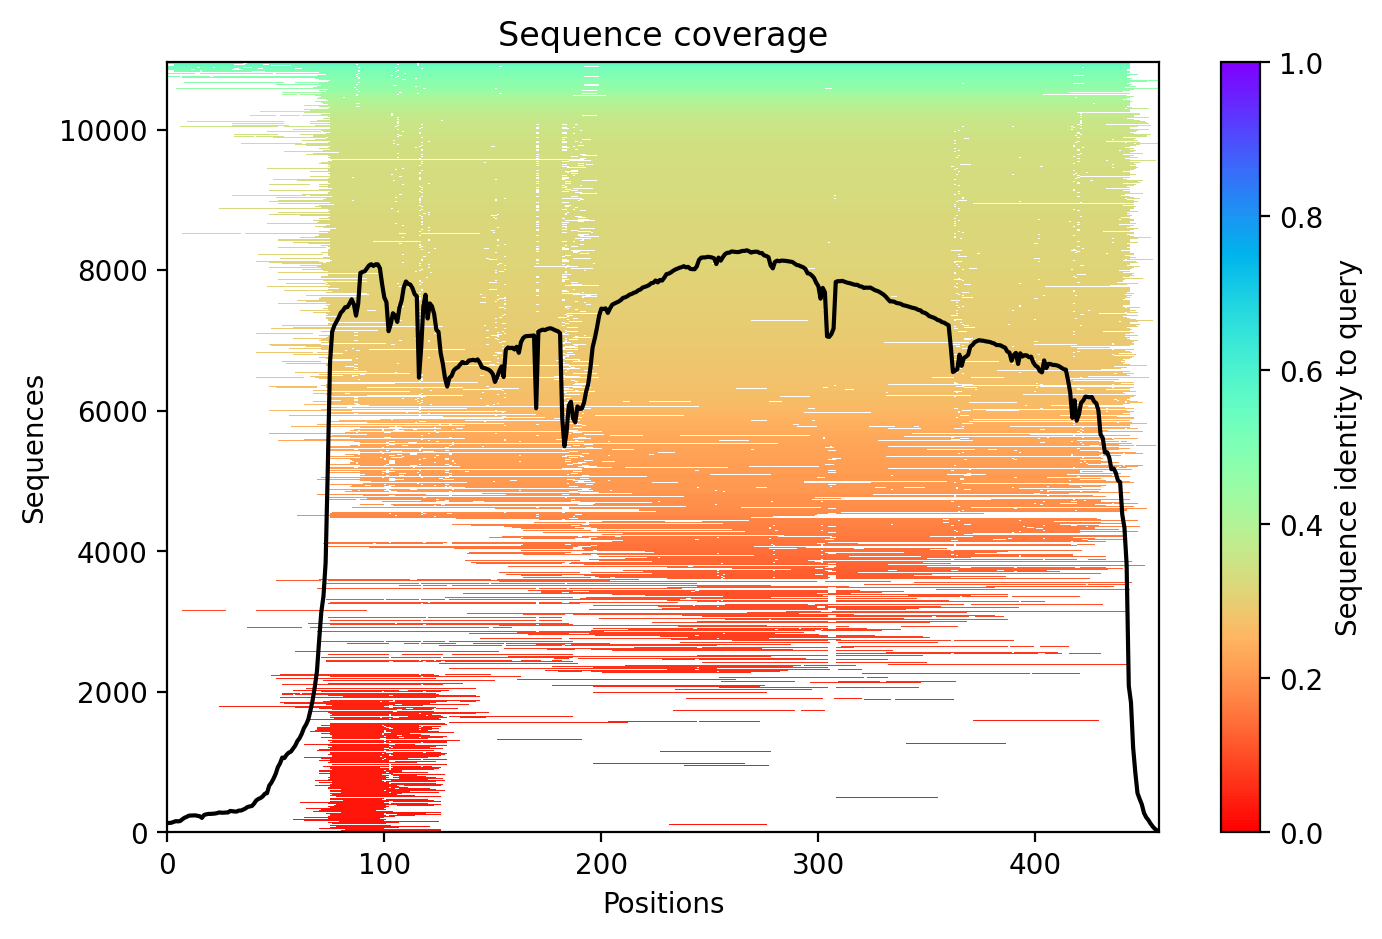
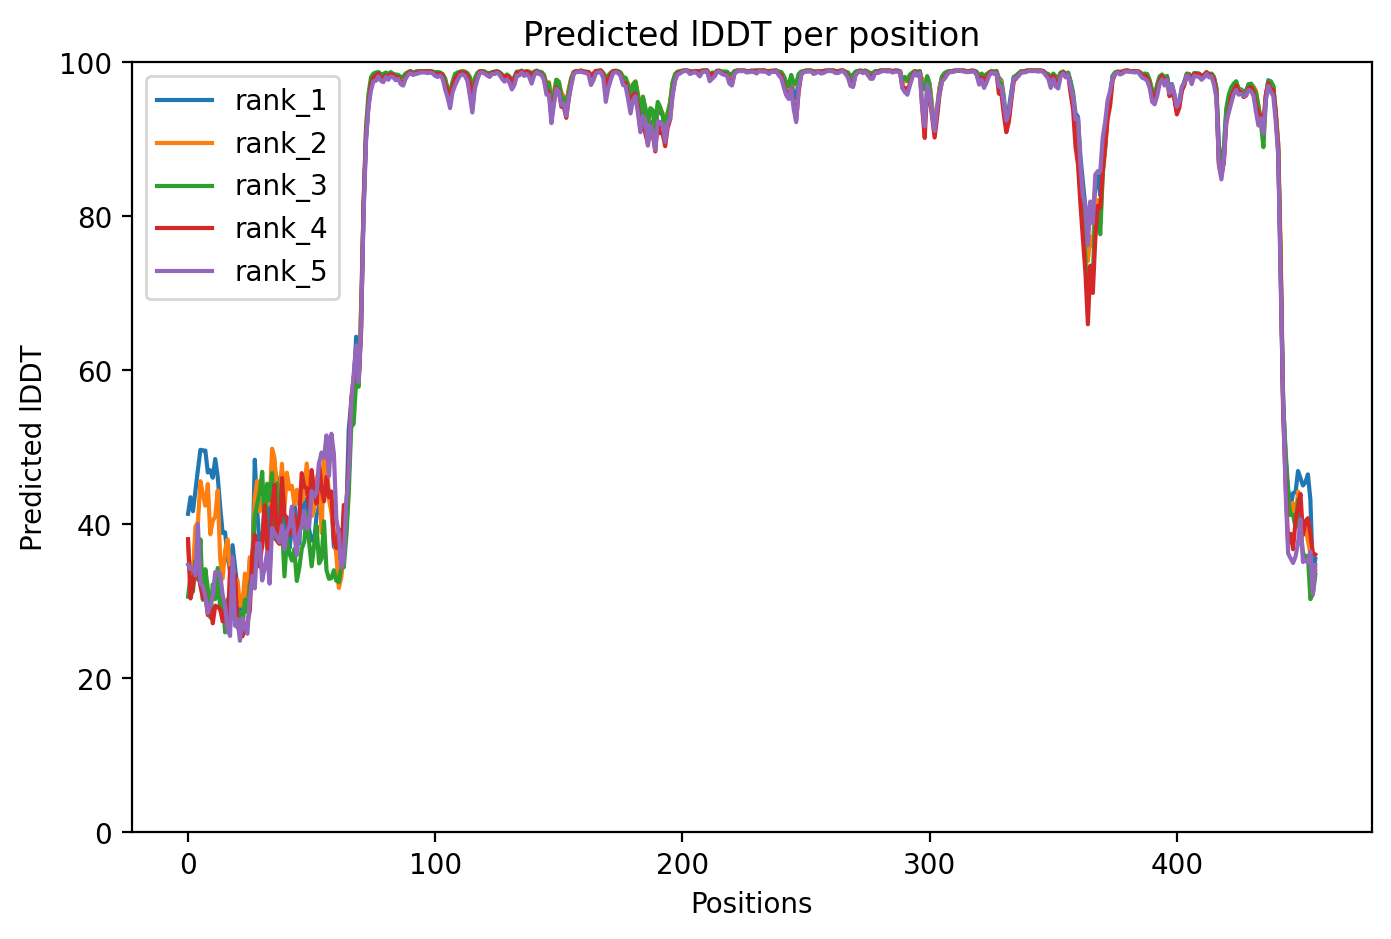

In [7]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = ""
pae_file = os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png")
if os.path.isfile(pae_file):
    pae = image_to_data_url(pae_file)
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  { '<!--' if pae == '' else '' }<img src="{pae}" class="full" />{ '-->' if pae == '' else '' }
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))

In [8]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Uploaded mp4_tomato_e68bf.result.zip to Google Drive with ID 1EqaZ_El-lwK26TlJWvInLbISprlEo4Du


# Instructions <a name="Instructions"></a>
For detailed instructions, tips and tricks, see recently published paper at [Nature Protocols](https://www.nature.com/articles/s41596-024-01060-5)

**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).


In [9]:
import os
import json
import glob
import numpy as np
import pandas as pd

def score_models(results_path):
    scores = []
    json_files = glob.glob(os.path.join(results_path, "*scores_rank_*.json"))

    if not json_files:
        print("⚠️ No JSON files found in the given folder.")
        return pd.DataFrame()

    for json_file in json_files:
        with open(json_file, 'r') as f:
            data = json.load(f)

        model_name = os.path.basename(json_file)

        # Check for required keys
        if "plddt" not in data:
            print(f"⚠️ 'plddt' not found in {model_name}")
            continue

        mean_plddt = np.mean(data["plddt"])
        iptm_score = data.get("iptm", 0.0)  # Default to 0 if not available

        # Final score: 70% pLDDT + 30% ipTM (rescaled)
        final_score = 0.7 * mean_plddt + 0.3 * iptm_score * 100

        scores.append({
            "model": model_name,
            "pLDDT": mean_plddt,
            "ipTM": iptm_score,
            "final_score": final_score
        })

    if not scores:
        print("⚠️ No valid models scored.")
        return pd.DataFrame()

    # Create and return DataFrame sorted by final_score
    df = pd.DataFrame(scores).sort_values(by="final_score", ascending=False).reset_index(drop=True)
    return df


# ==== 🚀 Run the Ranking ====
# Prompt the user for folder input
input_path = input("Enter the full path to the folder containing JSON result files: ").strip()

# Run the scoring
ranking_df = score_models(input_path)

# Display result
if not ranking_df.empty:
    print("\n📊 Ranked Models:")
    print(ranking_df)
    # Optional: save to CSV
    ranking_df.to_csv(os.path.join(input_path, "ranked_models.csv"), index=False)
    print(f"\n✅ Results saved to: {os.path.join(input_path, 'ranked_models.csv')}")
else:
    print("❌ No valid scores to rank.")

Enter the full path to the folder containing JSON result files: /content/mp4_tomato_e68bf

📊 Ranked Models:
                                               model      pLDDT  ipTM  \
0  mp4_tomato_e68bf_scores_rank_001_alphafold2_pt...  86.927265   0.0   
1  mp4_tomato_e68bf_scores_rank_002_alphafold2_pt...  86.789869   0.0   
2  mp4_tomato_e68bf_scores_rank_003_alphafold2_pt...  85.945689   0.0   
3  mp4_tomato_e68bf_scores_rank_004_alphafold2_pt...  85.803545   0.0   
4  mp4_tomato_e68bf_scores_rank_005_alphafold2_pt...  85.731422   0.0   

   final_score  
0    60.849085  
1    60.752908  
2    60.161982  
3    60.062481  
4    60.011996  

✅ Results saved to: /content/mp4_tomato_e68bf/ranked_models.csv


In [10]:
import time
import psutil
import tracemalloc
import os

# Start timing and memory tracking
start_time = time.time()
tracemalloc.start()

# Optional: track memory usage using psutil for your current process
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 * 1024)  # Convert bytes to MB

# === Run your AlphaFold2 training function here ===
# Example placeholder:
# run_alphafold2_model(your_input_params)
# ===============================================

# End timing and memory tracking
end_time = time.time()
elapsed_time = end_time - start_time

current_mem = process.memory_info().rss / (1024 * 1024)  # After execution
peak_mem, _ = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"Elapsed Time: {elapsed_time:.2f} seconds")
print(f"Start Memory Usage: {start_mem:.2f} MB")
print(f"End Memory Usage: {current_mem:.2f} MB")
print(f"Peak Memory Usage (via tracemalloc): {peak_mem / (1024 * 1024):.2f} MB")


Elapsed Time: 0.00 seconds
Start Memory Usage: 4392.62 MB
End Memory Usage: 4392.62 MB
Peak Memory Usage (via tracemalloc): 0.00 MB


2025-06-07 14:36:13,170 Running on GPU
2025-06-07 14:36:13,189 Found 5 citations for tools or databases
2025-06-07 14:36:13,190 Query 1/1: mp4_tomato_e68bf (length 457)


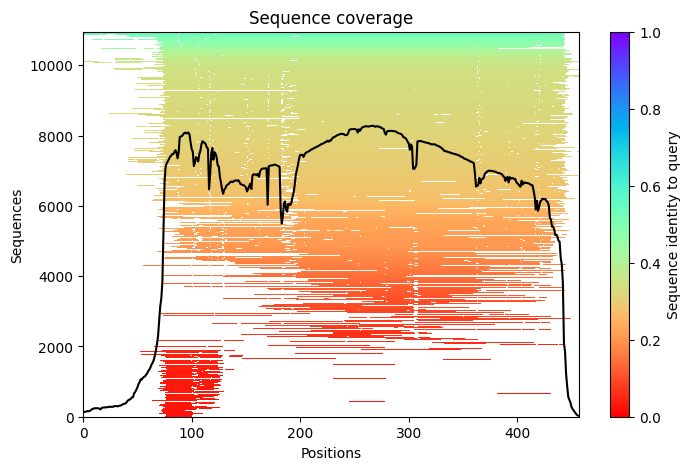

2025-06-07 14:36:19,333 Setting max_seq=512, max_extra_seq=5120
2025-06-07 14:38:07,928 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=85.1 pTM=0.808
2025-06-07 14:39:01,268 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=85.4 pTM=0.816 tol=7.73
2025-06-07 14:39:54,742 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=85.7 pTM=0.819 tol=6.05
2025-06-07 14:40:48,751 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=85.8 pTM=0.82 tol=2.17
2025-06-07 14:40:48,769 alphafold2_ptm_model_1_seed_000 took 248.7s (3 recycles)


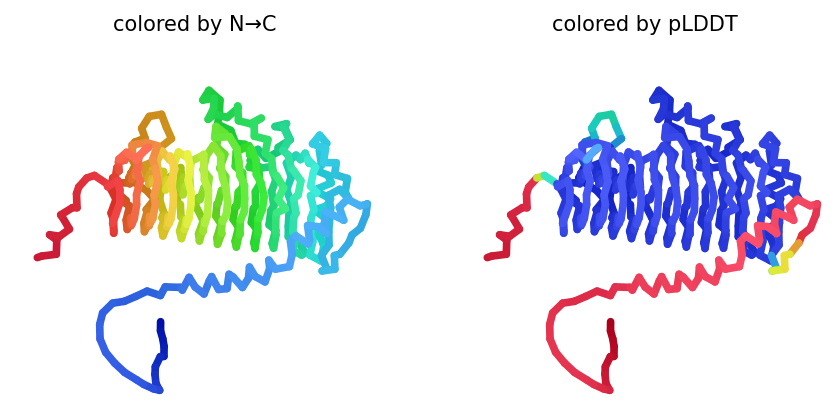

2025-06-07 14:41:49,722 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=85.8 pTM=0.816
2025-06-07 14:42:43,307 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=85.8 pTM=0.822 tol=5.53
2025-06-07 14:43:36,842 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=85.9 pTM=0.819 tol=2.03
2025-06-07 14:44:30,291 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=85.8 pTM=0.818 tol=0.985
2025-06-07 14:44:30,295 alphafold2_ptm_model_2_seed_000 took 214.3s (3 recycles)


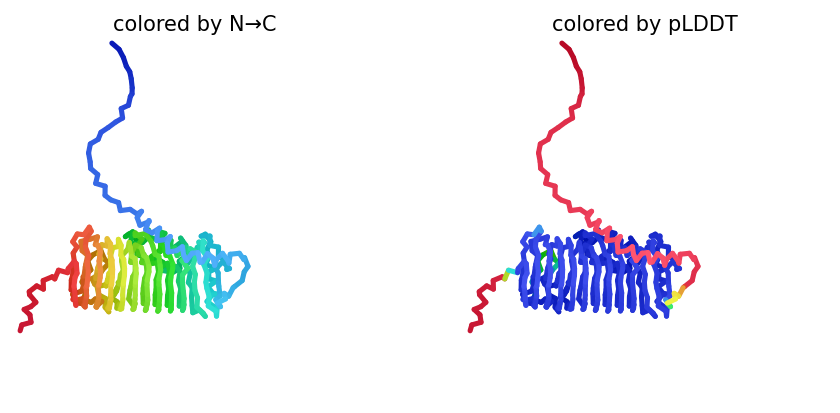

2025-06-07 14:45:29,964 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=85.9 pTM=0.81
2025-06-07 14:46:23,465 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=86.7 pTM=0.824 tol=7.58
2025-06-07 14:47:16,950 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=86.8 pTM=0.825 tol=0.981
2025-06-07 14:48:10,461 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=86.8 pTM=0.819 tol=1.6
2025-06-07 14:48:10,463 alphafold2_ptm_model_3_seed_000 took 214.2s (3 recycles)


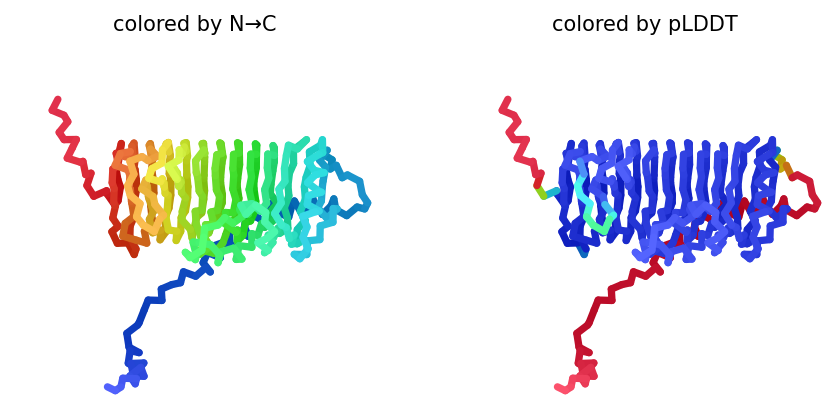

2025-06-07 14:49:09,971 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=86 pTM=0.815
2025-06-07 14:50:03,362 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=86.3 pTM=0.822 tol=12
2025-06-07 14:50:56,731 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=86.7 pTM=0.827 tol=3.58
2025-06-07 14:51:50,189 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=86.9 pTM=0.823 tol=0.643
2025-06-07 14:51:50,191 alphafold2_ptm_model_4_seed_000 took 213.9s (3 recycles)


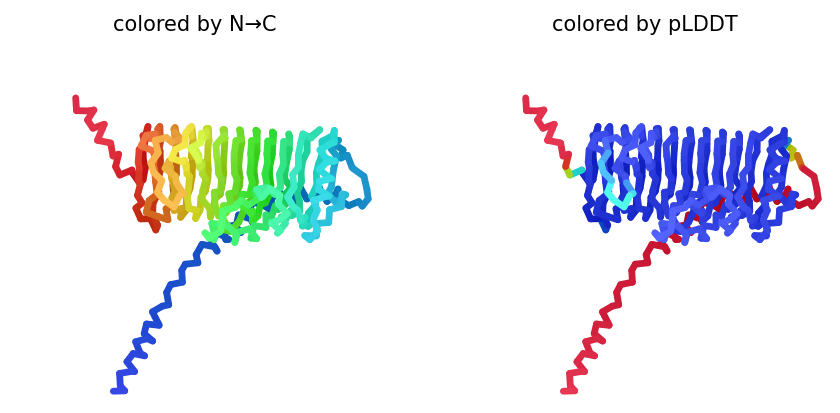

2025-06-07 14:52:48,631 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=85.6 pTM=0.815
2025-06-07 14:53:42,046 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=85.7 pTM=0.817 tol=2.71
2025-06-07 14:54:35,747 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=85.6 pTM=0.813 tol=3.69
2025-06-07 14:55:29,285 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=85.9 pTM=0.814 tol=3.57
2025-06-07 14:55:29,287 alphafold2_ptm_model_5_seed_000 took 214.3s (3 recycles)


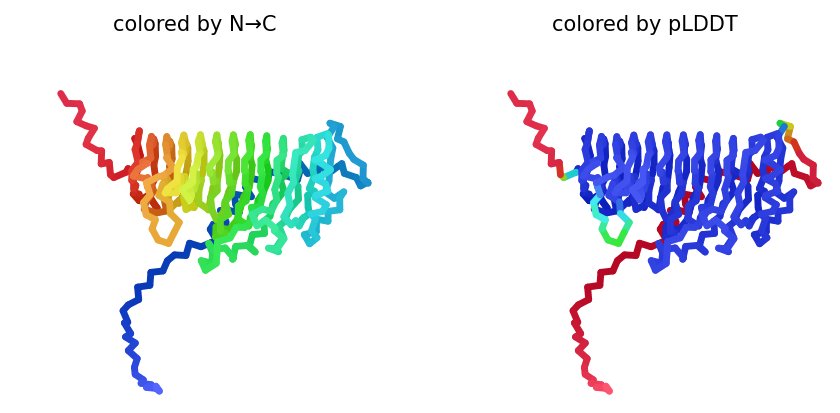

2025-06-07 14:55:34,146 reranking models by 'plddt' metric
2025-06-07 14:55:34,147 rank_001_alphafold2_ptm_model_4_seed_000 pLDDT=86.9 pTM=0.823
2025-06-07 14:55:34,148 rank_002_alphafold2_ptm_model_3_seed_000 pLDDT=86.8 pTM=0.819
2025-06-07 14:55:34,149 rank_003_alphafold2_ptm_model_5_seed_000 pLDDT=85.9 pTM=0.814
2025-06-07 14:55:34,150 rank_004_alphafold2_ptm_model_2_seed_000 pLDDT=85.8 pTM=0.818
2025-06-07 14:55:34,151 rank_005_alphafold2_ptm_model_1_seed_000 pLDDT=85.8 pTM=0.82
2025-06-07 14:55:41,402 Done
⏱️ Elapsed Time: 1170.04 seconds
📦 Start Memory: 4392.62 MB
📦 End Memory: 4507.70 MB
📈 Peak Memory (heap): 75.43 MB


In [11]:
import time
import tracemalloc
import psutil

# Start tracking
start_time = time.time()
tracemalloc.start()
process = psutil.Process(os.getpid())
start_mem = process.memory_info().rss / (1024 * 1024)  # in MB

# Run AlphaFold2 prediction
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    calc_extra_ptm=calc_extra_ptm,
)

# Post-processing: zip results
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

# End tracking
end_time = time.time()
elapsed_time = end_time - start_time
current_mem = process.memory_info().rss / (1024 * 1024)
peak_mem, _ = tracemalloc.get_traced_memory()
tracemalloc.stop()

print(f"⏱️ Elapsed Time: {elapsed_time:.2f} seconds")
print(f"📦 Start Memory: {start_mem:.2f} MB")
print(f"📦 End Memory: {current_mem:.2f} MB")
print(f"📈 Peak Memory (heap): {peak_mem / (1024 * 1024):.2f} MB")


GNN PREDICTIONS

In [1]:
!pip install torch torchvision torchaudio
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install networkx matplotlib psutil


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [2]:
pip uninstall torch-scatter -y


Found existing installation: torch-scatter 2.1.2+pt20cpu
Uninstalling torch-scatter-2.1.2+pt20cpu:
  Successfully uninstalled torch-scatter-2.1.2+pt20cpu


In [3]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.5 MB/s eta 0:00:00


In [4]:
pip install biopython


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


GNN PROTEIN GRAPH

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
<ipython-input-6-8d91792b82da>:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  coords_tensor = torch.tensor(coords, dtype=torch.float)


Average pLDDT from PDB: 87.31


<ipython-input-6-8d91792b82da>:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


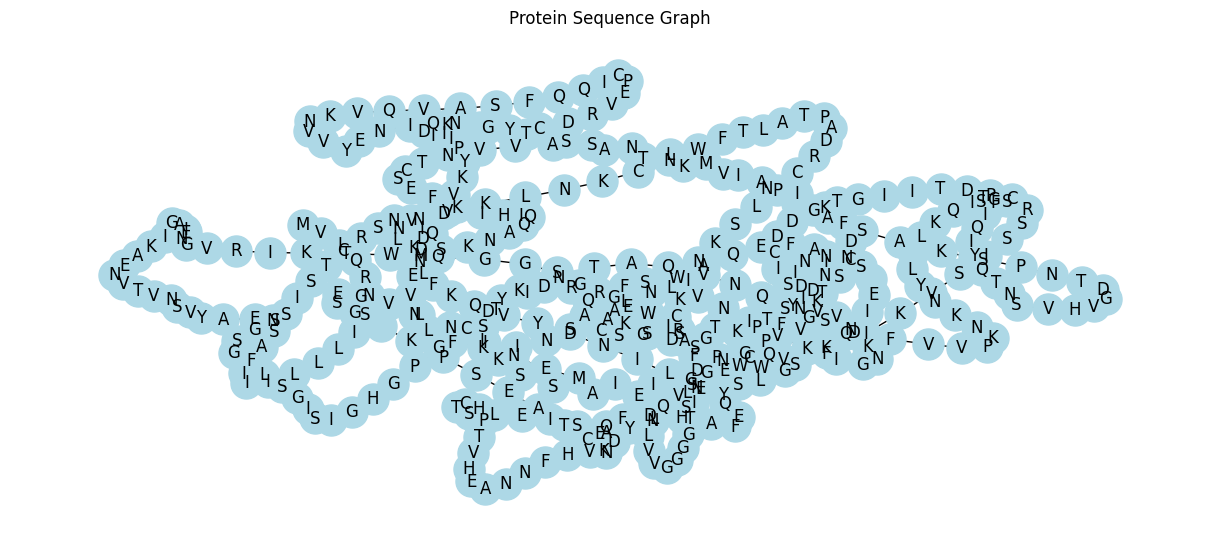

Graph saved to protein_graph.png
Epoch 0 | Loss: 216.2066
Epoch 10 | Loss: 215.7593
Epoch 20 | Loss: 215.3049
Epoch 30 | Loss: 214.8212
Epoch 40 | Loss: 214.2992
Epoch 50 | Loss: 213.7158
Epoch 60 | Loss: 213.0704
Epoch 70 | Loss: 212.3528
Epoch 80 | Loss: 211.5657
Epoch 90 | Loss: 210.7351
RMSD between predicted and ground truth: 25.0977
Coordinates saved to predicted_coordinates_with_plddt.csv
Scores saved to evaluation_scores.csv
Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
import pickle
import csv

# === Encoding ===
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_dict = {aa: i for i, aa in enumerate(amino_acids)}

def encode_sequence(seq):
    vec = []
    for aa in seq:
        one_hot = [0] * 20
        if aa in aa_dict:
            one_hot[aa_dict[aa]] = 1
        vec.append(one_hot)
    return torch.tensor(vec, dtype=torch.float)

def create_edges(n):
    edges = [[i, i + 1] for i in range(n - 1)]
    edges += [[i + 1, i] for i in range(n - 1)]
    return torch.tensor(edges, dtype=torch.long).t()

# === GNN Model ===
class StructureGNN(nn.Module):
    def __init__(self, input_dim=20, hidden_dim=64):
        super(StructureGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 3)  # output 3D coordinates

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# === Load Ground Truth CA Coordinates and pLDDT ===
def get_ca_coordinates_and_plddt_with_indices(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    coords = []
    plddt_scores = []
    indices = []
    for i, residue in enumerate(structure[0]["A"]):
        if "CA" in residue:
            ca_atom = residue["CA"]
            coords.append(ca_atom.coord)
            plddt_scores.append(ca_atom.get_bfactor())
            indices.append(i)
    coords_tensor = torch.tensor(coords, dtype=torch.float)
    return coords_tensor, plddt_scores, indices

# === Graph Creation ===
def generate_graph(sequence):
    x = encode_sequence(sequence)
    edge_index = create_edges(len(sequence))
    data = Data(x=x, edge_index=edge_index)

    G = nx.Graph()
    for i, aa in enumerate(sequence):
        G.add_node(i, label=aa)
    for src, dst in edge_index.t().tolist():
        G.add_edge(src, dst)
    return G, data

# === RMSD Calculation ===
def calculate_rmsd(predicted, target):
    assert predicted.shape == target.shape, "Shape mismatch for RMSD calculation"
    diff = predicted - target
    rmsd = torch.sqrt(torch.mean(torch.sum(diff ** 2, dim=1)))
    return rmsd.item()

# === Training Loop ===
def train_structure_gnn(data, target_coords, epochs=100, lr=0.001):
    model = StructureGNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    data = data.to(device)
    target_coords = target_coords.to(device)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(data)
        loss = criterion(pred, target_coords)
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {loss.item():.4f}")
    return model, pred.detach().cpu()

# === Visualization Helper ===
def visualize_graph(G, sequence, save_path="protein_graph.png"):
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G, seed=42)
    labels = {i: aa for i, aa in enumerate(sequence)}
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_color='lightblue', node_size=500)
    plt.title("Protein Sequence Graph")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Graph saved to {save_path}")

# === Save Coordinates to CSV with pLDDT ===
def save_coordinates_csv(coords, plddt_scores=None, filename="predicted_coordinates.csv"):
    coords_np = coords.numpy()
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        header = ["Residue_Index", "X", "Y", "Z"]
        if plddt_scores is not None:
            header.append("pLDDT")
        writer.writerow(header)

        for i, (x, y, z) in enumerate(coords_np):
            row = [i, x, y, z]
            if plddt_scores is not None and i < len(plddt_scores):
                row.append(plddt_scores[i])
            writer.writerow(row)
    print(f"Coordinates saved to {filename}")

def save_scores_csv(plddt, rmsd, filename="evaluation_scores.csv"):
    with open(filename, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["Average_pLDDT", "RMSD"])
        writer.writerow([plddt, rmsd])
    print(f"Scores saved to {filename}")

# === Main Execution ===
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    sequence = "MVIQRNSILLLIIIFASSISTCRSNVIDDNLFKQVYDNILEQEFAHDFQAYLSYLSKNIE SNNNIDKVDKNGIKVINVLSFGAKGDGKTYDNIAFEQAWNEACSSRTPVQFVVPKNKNYL LKQITFSGPCRSSISVKIFGSLEASSKISDYKDRRLWIAFDSVQNLVVGGGGTINGNGQV WWPSSCKINKSLPCRDAPTALTFWNCKNLKVNNLKSKNAQQIHIKFESCTNVVASNLMIN ASAKSPNTDGVHVSNTQYIQISDTIIGTGDDCISIVSGSQNVQATNITCGPGHGISIGSL GSGNSEAYVSNVTVNEAKIIGAENGVRIKTWQGGSGQASNIKFLNVEMQDVKYPIIIDQN YCDRVEPCIQQFSAVQVKNVVYENIKGTSATKVAIKFDCSTNFPCEGIIMENINLVGESG KPSEATCKNVHFNNAEHVTPHCTSLEISEDEALLYNY"
    pdb_file = "/content/drive/MyDrive/tomato_GT/AF-P05117-F1-model_v4.pdb"

    coords_gt, plddt_scores, valid_indices = get_ca_coordinates_and_plddt_with_indices(pdb_file)

    # Filter the sequence using only residues that have coordinates
    filtered_sequence = ''.join([sequence[i] for i in valid_indices])

    avg_plddt = sum(plddt_scores) / len(plddt_scores)
    print(f"Average pLDDT from PDB: {avg_plddt:.2f}")

    G, data = generate_graph(filtered_sequence)
    visualize_graph(G, filtered_sequence)

    model, pred_coords = train_structure_gnn(data, coords_gt)

    rmsd_score = calculate_rmsd(pred_coords, coords_gt)
    print(f"RMSD between predicted and ground truth: {rmsd_score:.4f}")

    save_coordinates_csv(pred_coords, plddt_scores, "predicted_coordinates_with_plddt.csv")
    save_scores_csv(avg_plddt, rmsd_score, "evaluation_scores.csv")

    # Save artifacts
    torch.save(data, "structure_data.pt")
    torch.save(model.state_dict(), "structure_gnn.pth")
    np.save("predicted_coords.npy", pred_coords.numpy())
    with open("structure_graph.gpickle", "wb") as f:
        pickle.dump(G, f)

    print("Saved model, graph, predicted coordinates with pLDDT, and evaluation scores.")


PLDDT SCORES FOR GNN MODEL

In [7]:
import matplotlib.pyplot as plt
import csv

def plot_plddt_from_csv(csv_file, save_path="plddt_scores_plot.png"):
    residue_indices = []
    plddt_scores = []

    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            if 'pLDDT' in row:
                residue_indices.append(int(row['Residue_Index']))
                plddt_scores.append(float(row['pLDDT']))

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.plot(residue_indices, plddt_scores, label="pLDDT Score", color="blue")

    # Confidence thresholds
    plt.axhline(y=90, color='green', linestyle='--', label='Very High Confidence (>=90)')
    plt.axhline(y=70, color='orange', linestyle='--', label='Confident (70-90)')
    plt.axhline(y=50, color='red', linestyle='--', label='Low Confidence (<70)')

    plt.xlabel("Residue Index")
    plt.ylabel("pLDDT Score")
    plt.title("Per-Residue pLDDT Confidence Scores")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Plot saved to {save_path}")


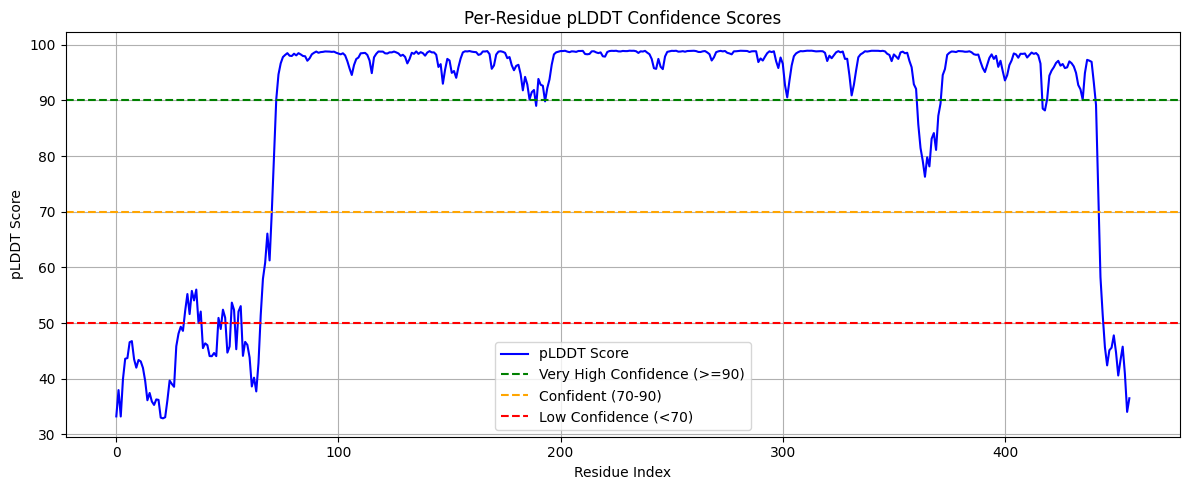

Plot saved to plddt_scores_plot.png


In [8]:
plot_plddt_from_csv("/content/predicted_coordinates_with_plddt.csv")


PLDDT SCORES FOR ALPHAFOLD2 MODEL

Residue ID | pLDDT Score
-------------------------
        1 | 34.78
        2 | 34.19
        3 | 34.41
        4 | 33.38
        5 | 40.06
        6 | 32.38
        7 | 31.95
        8 | 30.70
        9 | 28.47
       10 | 29.44
       11 | 30.66
       12 | 33.81
       13 | 33.81
       14 | 33.59
       15 | 30.86
       16 | 29.38
       17 | 26.31
       18 | 25.52
       19 | 35.75
       20 | 26.84
       21 | 27.73
       22 | 24.89
       23 | 27.84
       24 | 26.48
       25 | 25.80
       26 | 30.52
       27 | 33.34
       28 | 31.69
       29 | 37.56
       30 | 37.50
       31 | 32.72
       32 | 34.41
       33 | 36.38
       34 | 32.31
       35 | 39.53
       36 | 38.84
       37 | 38.38
       38 | 37.69
       39 | 39.88
       40 | 36.78
       41 | 39.09
       42 | 39.72
       43 | 42.31
       44 | 38.78
       45 | 36.03
       46 | 38.91
       47 | 39.78
       48 | 41.78
       49 | 39.44
       50 | 39.75
       51 | 44.34
       52 | 43.56
       53 | 4

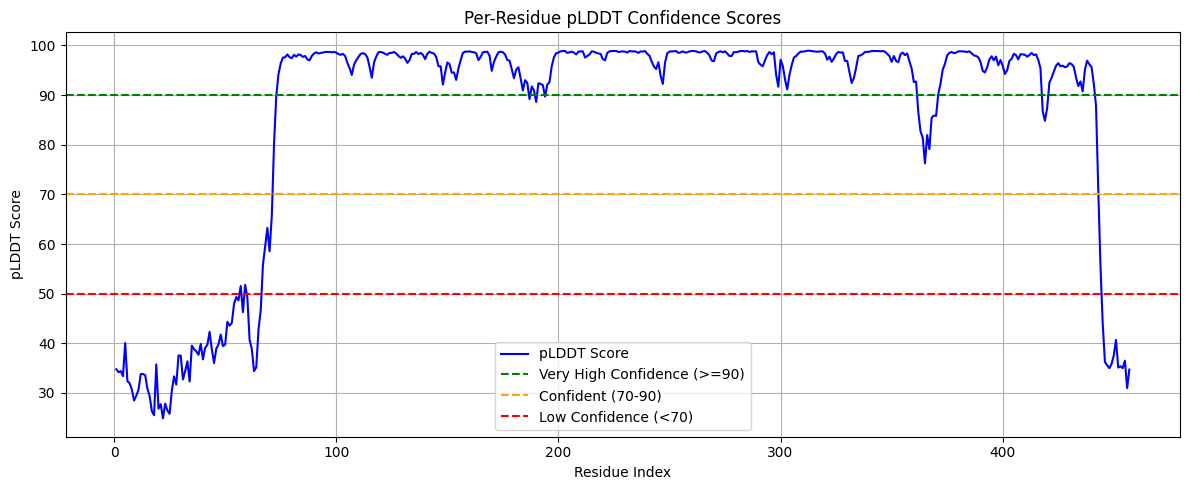

In [9]:
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
import csv

def extract_plddt_from_pdb(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    plddt_scores = []
    residue_ids = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    ca_atom = residue['CA']
                    b_factor = ca_atom.get_bfactor()
                    plddt_scores.append(b_factor)
                    res_id = residue.get_id()[1]  # residue number
                    residue_ids.append(res_id)

    return residue_ids, plddt_scores

def plot_plddt_scores(residue_ids, plddt_scores):
    plt.figure(figsize=(12, 5))
    plt.plot(residue_ids, plddt_scores, color='blue', label='pLDDT Score')
    plt.axhline(y=90, color='green', linestyle='--', label='Very High Confidence (>=90)')
    plt.axhline(y=70, color='orange', linestyle='--', label='Confident (70-90)')
    plt.axhline(y=50, color='red', linestyle='--', label='Low Confidence (<70)')
    plt.xlabel('Residue Index')
    plt.ylabel('pLDDT Score')
    plt.title('Per-Residue pLDDT Confidence Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def save_plddt_to_csv(residue_ids, plddt_scores, output_file="plddt_scores.csv"):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Residue ID", "pLDDT Score"])
        for rid, score in zip(residue_ids, plddt_scores):
            writer.writerow([rid, f"{score:.2f}"])
    print(f"Saved pLDDT scores to {output_file}")

# === Usage ===
pdb_path = "/content/mp4_tomato_e68bf/mp4_tomato_e68bf_unrelaxed_rank_005_alphafold2_ptm_model_1_seed_000.pdb"  # Replace with your PDB file
res_ids, plddt_vals = extract_plddt_from_pdb(pdb_path)

# Print scores to console
print("Residue ID | pLDDT Score")
print("-------------------------")
for rid, score in zip(res_ids, plddt_vals):
    print(f"{rid:9} | {score:.2f}")

# Save to CSV
save_plddt_to_csv(res_ids, plddt_vals)

# Plot scores
plot_plddt_scores(res_ids, plddt_vals)


CORRELATION BETWEEN GNN AND ALPHAFOLD PLDDT SCORES

Pearson Correlation: 0.9937
Spearman Correlation: 0.9913


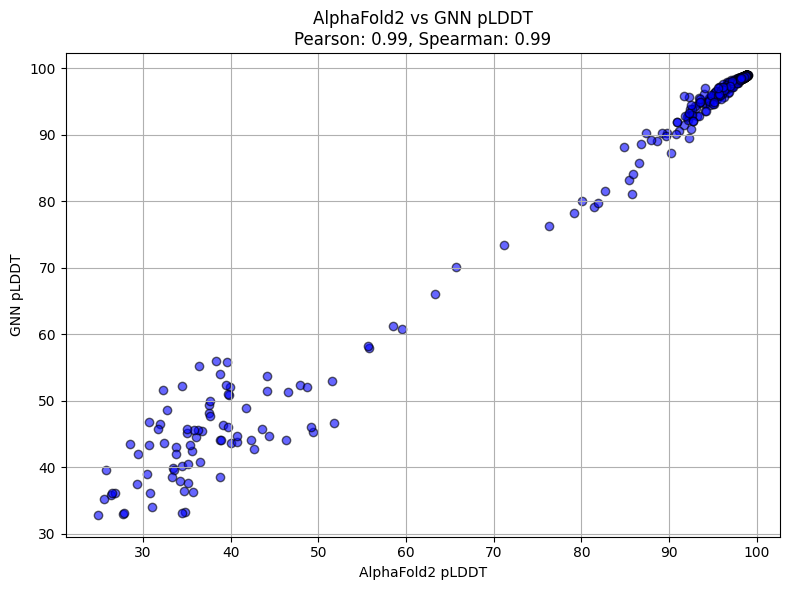

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load CSV files
df_gnn = pd.read_csv("/content/predicted_coordinates_with_plddt.csv")
df_af2 = pd.read_csv("/content/plddt_scores.csv")

# Extract pLDDT scores
gnn_scores = df_gnn["pLDDT"].to_numpy()
af2_scores = df_af2["pLDDT Score"].to_numpy()

# Ensure equal length
min_len = min(len(gnn_scores), len(af2_scores))
gnn_scores = gnn_scores[:min_len]
af2_scores = af2_scores[:min_len]

# Compute correlations
pearson_corr, _ = pearsonr(af2_scores, gnn_scores)
spearman_corr, _ = spearmanr(af2_scores, gnn_scores)

# Print results
print(f"Pearson Correlation: {pearson_corr:.4f}")
print(f"Spearman Correlation: {spearman_corr:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(af2_scores, gnn_scores, alpha=0.6, color='blue', edgecolors='k')
plt.title(f'AlphaFold2 vs GNN pLDDT\nPearson: {pearson_corr:.2f}, Spearman: {spearman_corr:.2f}')
plt.xlabel('AlphaFold2 pLDDT')
plt.ylabel('GNN pLDDT')
plt.grid(True)
plt.tight_layout()
plt.savefig("plddt_correlation_plot.png")
plt.show()


COLUMNS PRESENT IN THE CSV FILES

In [11]:
import pandas as pd

# Replace with your actual file names
df_gnn = pd.read_csv("/content/predicted_coordinates_with_plddt.csv")
df_af2 = pd.read_csv("/content/plddt_scores.csv")

print("GNN columns:", df_gnn.columns)
print("AlphaFold2 columns:", df_af2.columns)


GNN columns: Index(['Residue_Index', 'X', 'Y', 'Z', 'pLDDT'], dtype='object')
AlphaFold2 columns: Index(['Residue ID', 'pLDDT Score'], dtype='object')
